In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from line_profiler import LineProfiler
%load_ext line_profiler
from math import pi, ceil, factorial, sqrt
from matplotlib.transforms import Affine2D
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Arc, Polygon, Rectangle, Circle, Wedge, FancyArrow
from matplotlib.lines import Line2D

plt.style.use('seaborn')
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

legend_opts = {
    'fontsize':15,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

def savefig(fig, filename, **kwargs):
    fig.savefig(f'../viz/{filename}', bbox_inches='tight', **kwargs)

/tmp/ipykernel_75/1252710908.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def extract_timings(profile, n_trials):
    stats = profile.get_stats()
    timings = list(stats.timings.values())[0]
    milisecs = [time * stats.unit * 1000 / n_trials for line, hit, time in timings]
    return np.array(milisecs)

In [3]:
n_trials = 1000
n_samples = 1000000

In [4]:
profile_box = LineProfiler()
@profile_box
def generate_box(n_samples):
    # 1. Generate U1 and U2
    rng = np.random.RandomState(seed=42)
    u1, u2 = rng.uniform(size=n_samples), rng.uniform(size=n_samples)

    # 2. Transform U1 to cos & sin of theta
    theta = 2*pi*u1
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)

    # 3. Tranform U2 to R
    r = np.sqrt(-2*np.log(u2))

    # 4. Calculate X & Y from R and cos & sin of theta
    x, y = r*cos_theta, r*sin_theta
    return x, y

for _ in range(n_trials):
    xs_box, ys_box = generate_box(n_samples)
timings_box = extract_timings(profile_box, n_trials)
print(f'Total ms per trial: {sum(timings_box)}')
profile_box.print_stats(output_unit=1e-3)

Total ms per trial: 80.195944181
Timer unit: 0.001 s

Total time: 80.1959 s
File: /tmp/ipykernel_75/1134451318.py
Function: generate_box at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile_box
     3                                           def generate_box(n_samples):
     4                                               # 1. Generate U1 and U2
     5      1000        277.6      0.3      0.3      rng = np.random.RandomState(seed=42)
     6      1000      13492.3     13.5     16.8      u1, u2 = rng.uniform(size=n_samples), rng.uniform(size=n_samples)
     7                                           
     8                                               # 2. Transform U1 to cos & sin of theta
     9      1000        633.9      0.6      0.8      theta = 2*pi*u1
    10      1000      38812.6     38.8     48.4      cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    11                                        

In [5]:
profile_neumann = LineProfiler()
@profile_neumann
def generate_neumann(n_samples):
    # 1. Generate U1 and U2
    rng = np.random.RandomState(seed=42)
    u1, u2 = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))

    # 2. Transform U1 & U2 to cos & sin of theta
    u, v = 2*u1 - 1, 2*u2 - 1
    t = u**2 + v**2
    is_unit_circle = t <= 1
    u, v, t = u[is_unit_circle], v[is_unit_circle], t[is_unit_circle]
    sqrt_t = np.sqrt(t)
    cos_theta, sin_theta = u / sqrt_t, v / sqrt_t

    # 1. Generate U3
    u3 = rng.uniform(size=len(u))

    # 3. Transform U3 to R
    r = np.sqrt(-2*np.log(u3))

    # 4. Calculate X & Y from R and cos & sin of theta
    x, y = r*cos_theta, r*sin_theta
    return x, y

for _ in range(n_trials):
    xs_neumann, ys_neumann = generate_neumann(n_samples)
timings_neumann = extract_timings(profile_neumann, n_trials)
print(f'Total ms per trial: {sum(timings_neumann)}')
profile_neumann.print_stats(output_unit=1e-3)

Total ms per trial: 70.871086155
Timer unit: 0.001 s

Total time: 70.8711 s
File: /tmp/ipykernel_75/877022773.py
Function: generate_neumann at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile_neumann
     3                                           def generate_neumann(n_samples):
     4                                               # 1. Generate U1 and U2
     5      1000        281.8      0.3      0.4      rng = np.random.RandomState(seed=42)
     6      1000      17497.8     17.5     24.7      u1, u2 = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))
     7                                           
     8                                               # 2. Transform U1 & U2 to cos & sin of theta
     9      1000       2510.2      2.5      3.5      u, v = 2*u1 - 1, 2*u2 - 1
    10      1000       2125.5      2.1      3.0      t = u**2 + v**2
    11      1000        488.9     

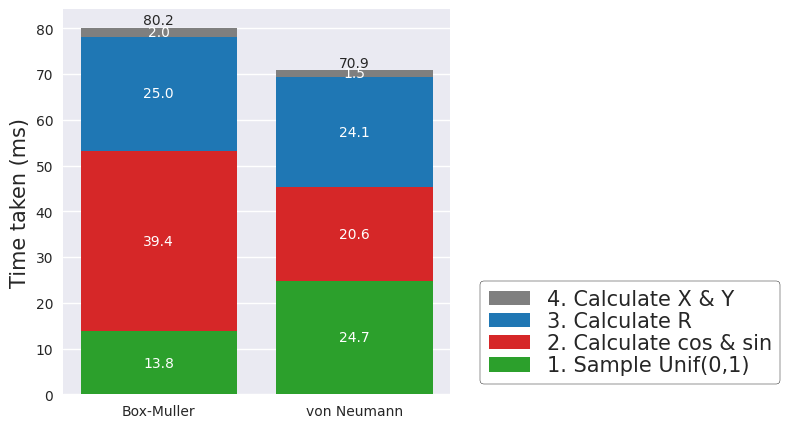

In [6]:
timings1 = np.array([timings_box[[0, 1]].sum(), timings_neumann[[0, 1, 8]].sum()])
timings2 = np.array([timings_box[[2, 3]].sum(), timings_neumann[2:8].sum()])
timings3 = np.array([timings_box[[4]].sum(), timings_neumann[[9]].sum()])
timings4 = np.array([timings_box[[5]].sum(), timings_neumann[[10]].sum()])
methods = ['Box-Muller', 'von Neumann']

# Number of categories
x = np.arange(len(methods))

fig, ax = plt.subplots(figsize=(5, 5))
# Plot the bars
bar1 = ax.bar(x, timings1, label=1, color='tab:green')
bar2 = ax.bar(x, timings2, bottom=timings1, label=2, color='tab:red')
bar3 = ax.bar(x, timings3, bottom=timings1+timings2, label=3, color='tab:blue')
bar4 = ax.bar(x, timings4, bottom=timings1+timings2+timings3, label=4, color='tab:grey')

# Function to add text labels in the middle of each bar
def add_labels(bars, heights):
    for bar, height in zip(bars, heights):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-position
            bar.get_y() + height / 2,          # y-position (middle of the bar)
            f'{round(height, 1)}',                       # text label
            ha='center',                       # horizontal alignment
            va='center',                        # vertical alignment
            color='white'
        )

# Add labels to each series
add_labels(bar1, timings1)
add_labels(bar2, timings2)
add_labels(bar3, timings3)
add_labels(bar4, timings4)

# Add totals to top of bar
totals = timings1 + timings2 + timings3 + timings4
for index, total in enumerate(totals):
    ax.text(
        index,  # x-position
        total,                               # y-position
        f'{round(total, 1)}',                       # text label
        ha='center',                       # horizontal alignment
        va='bottom'                        # vertical alignment
    )

# Add labels, title, and legend
ax.set_ylabel('Time taken (ms)')
ax.set_xticks(x, methods)

# Add legend in reverse order
ax.legend([bar4, bar3, bar2, bar1], ['4. Calculate X & Y', '3. Calculate R', '2. Calculate cos & sin', '1. Sample Unif(0,1)'], 
        bbox_to_anchor=(1.05, 0), loc='lower left', **legend_opts)
ax.grid(axis='x')

# Show the plot
plt.show()

# Save image
savefig(fig, 'box_neumann_compare.png')

In [7]:
profile_marsaglia = LineProfiler()
@profile_marsaglia
def generate_marsaglia(n_samples):
    # 1. Generate U1 and U2
    rng = np.random.RandomState(seed=42)
    u1, u2 = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))

    # 2. Transform U1 & U2 to cos & sin of theta
    u, v = 2*u1 - 1, 2*u2 - 1
    t = u**2 + v**2
    is_unit_circle = t <= 1
    u, v, t = u[is_unit_circle], v[is_unit_circle], t[is_unit_circle]
    sqrt_t = np.sqrt(t)
    cos_theta, sin_theta = u / sqrt_t, v / sqrt_t

    # 3. Transform U3 to R
    r = np.sqrt(-2*np.log(t))

    # 4. Calculate X & Y from R and cos & sin of theta
    x, y = r*cos_theta, r*sin_theta
    return x, y

for _ in range(n_trials):
    xs_marsaglia, ys_marsaglia = generate_marsaglia(n_samples)
timings_marsaglia = extract_timings(profile_marsaglia, n_trials)
print(f'Total ms per trial: {sum(timings_marsaglia)}')
profile_marsaglia.print_stats(output_unit=1e-3)

Total ms per trial: 64.42964302300001
Timer unit: 0.001 s

Total time: 64.4296 s
File: /tmp/ipykernel_75/3689341916.py
Function: generate_marsaglia at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile_marsaglia
     3                                           def generate_marsaglia(n_samples):
     4                                               # 1. Generate U1 and U2
     5      1000        293.6      0.3      0.5      rng = np.random.RandomState(seed=42)
     6      1000      17704.3     17.7     27.5      u1, u2 = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))
     7                                           
     8                                               # 2. Transform U1 & U2 to cos & sin of theta
     9      1000       2486.5      2.5      3.9      u, v = 2*u1 - 1, 2*u2 - 1
    10      1000       2148.5      2.1      3.3      t = u**2 + v**2
    11      1000      

In [8]:
profile_marsaglia_sqrt = LineProfiler()
@profile_marsaglia_sqrt
def generate_marsaglia_sqrt(n_samples):
    # 1. Generate U1 and U2
    rng = np.random.RandomState(seed=42)
    u1, u2 = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))

    # 2. Transform U1 & U2 to cos & sin of theta
    u, v = 2*u1 - 1, 2*u2 - 1
    t = u**2 + v**2
    is_unit_circle = t <= 1
    u, v, t = u[is_unit_circle], v[is_unit_circle], t[is_unit_circle]

    # 3. Transform U3 to R
    w = -2*np.log(t)

    # 4. Calculate X & Y from R and cos & sin of theta
    sqrt_combined = np.sqrt(w/t)
    x, y = u*sqrt_combined, v*sqrt_combined
    return x, y

for _ in range(n_trials):
    xs_marsaglia_sqrt, ys_marsaglia_sqrt = generate_marsaglia_sqrt(n_samples)
timings_marsaglia_sqrt = extract_timings(profile_marsaglia_sqrt, n_trials)
print(f'Total ms per trial: {sum(timings_marsaglia_sqrt)}')
profile_marsaglia_sqrt.print_stats(output_unit=1e-3)

Total ms per trial: 62.73579562500001
Timer unit: 0.001 s

Total time: 62.7358 s
File: /tmp/ipykernel_75/287041375.py
Function: generate_marsaglia_sqrt at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile_marsaglia_sqrt
     3                                           def generate_marsaglia_sqrt(n_samples):
     4                                               # 1. Generate U1 and U2
     5      1000        284.9      0.3      0.5      rng = np.random.RandomState(seed=42)
     6      1000      17442.3     17.4     27.8      u1, u2 = rng.uniform(size=ceil(n_samples*4/pi)), rng.uniform(size=ceil(n_samples*4/pi))
     7                                           
     8                                               # 2. Transform U1 & U2 to cos & sin of theta
     9      1000       2511.8      2.5      4.0      u, v = 2*u1 - 1, 2*u2 - 1
    10      1000       3097.2      3.1      4.9      t = u**2 + v**2
    11  

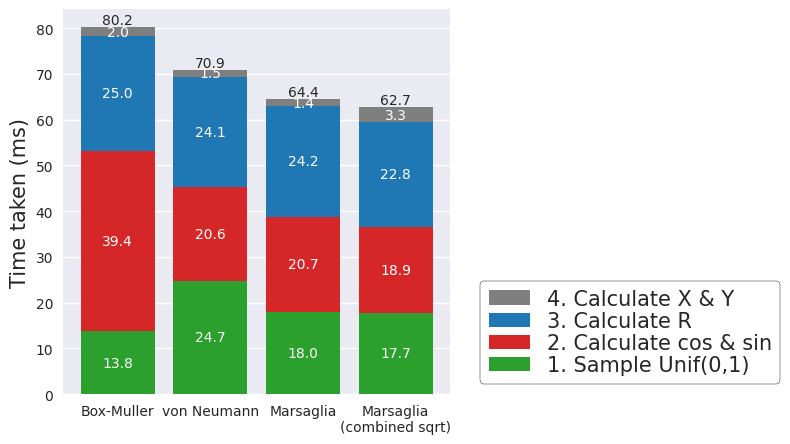

In [9]:
timings1 = np.array([timings_box[[0, 1]].sum(), timings_neumann[[0, 1, 8]].sum(), timings_marsaglia[[0, 1]].sum(), timings_marsaglia_sqrt[[0, 1]].sum()])
timings2 = np.array([timings_box[[2, 3]].sum(), timings_neumann[2:8].sum(), timings_marsaglia[2:8].sum(), timings_marsaglia_sqrt[2:6].sum()])
timings3 = np.array([timings_box[[4]].sum(), timings_neumann[[9]].sum(), timings_marsaglia[[8]].sum(), timings_marsaglia_sqrt[[6]].sum()])
timings4 = np.array([timings_box[[5]].sum(), timings_neumann[[10]].sum(), timings_marsaglia[[9]].sum(), timings_marsaglia_sqrt[[7, 8]].sum()])
methods = ['Box-Muller', 'von Neumann', 'Marsaglia', 'Marsaglia\n(combined sqrt)']

# Number of categories
x = np.arange(len(methods))

fig, ax = plt.subplots(figsize=(5, 5))
# Plot the bars
bar1 = ax.bar(x, timings1, label=1, color='tab:green')
bar2 = ax.bar(x, timings2, bottom=timings1, label=2, color='tab:red')
bar3 = ax.bar(x, timings3, bottom=timings1+timings2, label=3, color='tab:blue')
bar4 = ax.bar(x, timings4, bottom=timings1+timings2+timings3, label=4, color='tab:grey')

# Function to add text labels in the middle of each bar
def add_labels(bars, heights):
    for bar, height in zip(bars, heights):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-position
            bar.get_y() + height / 2,          # y-position (middle of the bar)
            f'{round(height, 1)}',                       # text label
            ha='center',                       # horizontal alignment
            va='center',                        # vertical alignment
            color='white'
        )

# Add labels to each series
add_labels(bar1, timings1)
add_labels(bar2, timings2)
add_labels(bar3, timings3)
add_labels(bar4, timings4)

# Add totals to top of bar
totals = timings1 + timings2 + timings3 + timings4
for index, total in enumerate(totals):
    ax.text(
        index,  # x-position
        total,                               # y-position
        f'{round(total, 1)}',                       # text label
        ha='center',                       # horizontal alignment
        va='bottom'                        # vertical alignment
    )

# Add labels, title, and legend
ax.set_ylabel('Time taken (ms)')
ax.set_xticks(x, methods)

# Add legend in reverse order
ax.legend([bar4, bar3, bar2, bar1], ['4. Calculate X & Y', '3. Calculate R', '2. Calculate cos & sin', '1. Sample Unif(0,1)'], 
        bbox_to_anchor=(1.05, 0), loc='lower left', **legend_opts)
ax.grid(axis='x')

# Show the plot
plt.show()

# Save image
savefig(fig, 'box_neumann_marsaglia_compare.png')

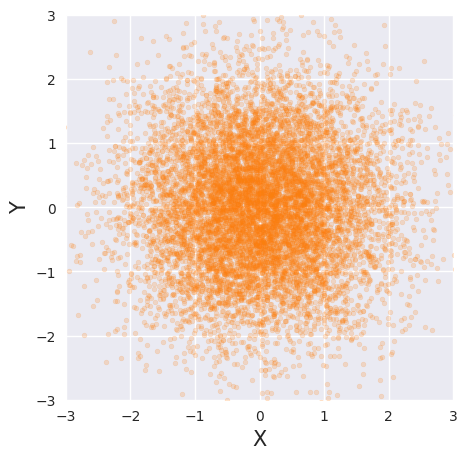

In [10]:
n_scatter = 10000
fig, ax = plt.subplots(figsize=(5, 5))
# ax.scatter(xs_box[:n_scatter], ys_box[:n_scatter], color='tab:blue', marker='.', alpha=0.2)
# ax.scatter(xs_neumann[:n_scatter], ys_neumann[:n_scatter], color='tab:green', marker='.', alpha=0.2)
ax.scatter(xs_marsaglia[:n_scatter], ys_marsaglia[:n_scatter], color='tab:orange', marker='.', alpha=0.2)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

# Plots & animations

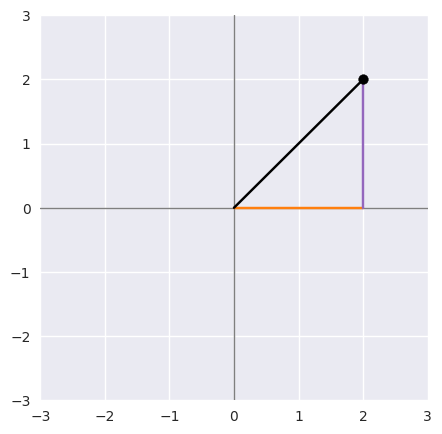

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(0, color='tab:gray', lw=1, zorder=10)
ax.axvline(0, color='tab:gray', lw=1, zorder=10)
ax.plot([0, 2], [0, 0], color='tab:orange', zorder=11)
ax.plot([2, 2], [0, 2], color='tab:purple', zorder=11)
ax.plot([0, 2], [0, 2], color='black', zorder=11)
ax.scatter(2, 2, color='black', zorder=12)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.show()
savefig(fig, 'xyrt.png')

In [ ]:
n_frames = 200
rng = np.random.RandomState(seed=42)
u1s, u2s = rng.uniform(size=ceil(n_frames*4/pi)), rng.uniform(size=ceil(n_frames*4/pi))

us, vs = 2*u1s - 1, 2*u2s - 1
ts = us**2 + vs**2
is_unit_circle = ts <= 1
usr, vsr, tsr = us[~is_unit_circle], vs[~is_unit_circle], ts[~is_unit_circle]

# Unit circle sampling
us, vs, ts = us[is_unit_circle], vs[is_unit_circle], ts[is_unit_circle]

# Bounding square sampling
# us, vs, ts = us[:n_frames], vs[:n_frames], ts[:n_frames]

thetas = np.arctan2(vs, us)
thetasr = np.arctan2(vsr, usr)
thetas[thetas < 0] += 2*pi
thetasr[thetasr < 0] += 2*pi

rounded_unit = pi/6
rounded_thetas = np.floor(thetas/rounded_unit)*rounded_unit
rounded_theta_counts = pd.Series(rounded_thetas).value_counts().sort_index()

rounded_t_unit = 0.2
rounded_ts = np.floor(ts/rounded_t_unit)*rounded_t_unit
rounded_t_counts = pd.Series(rounded_ts).value_counts().sort_index()

max_count = ceil(max(rounded_theta_counts.values) * 1.2)
max_t_count = ceil(max(rounded_t_counts.values) * 1.2)
max_count, max_t_count

(27, 53)

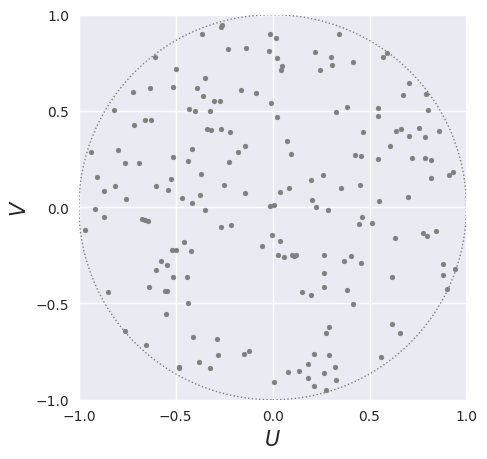

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

unit_circle = Circle((0, 0), 1, edgecolor='tab:gray', facecolor='none', linestyle='dotted', linewidth=1)
ax.add_patch(unit_circle)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks(np.linspace(-1, 1, 5))
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_xlabel(r'$U$')
ax.set_ylabel(r'$V$')

ax.scatter(us, vs, color='tab:gray', marker='.')
savefig(fig, 'uv_unit_circle.png')

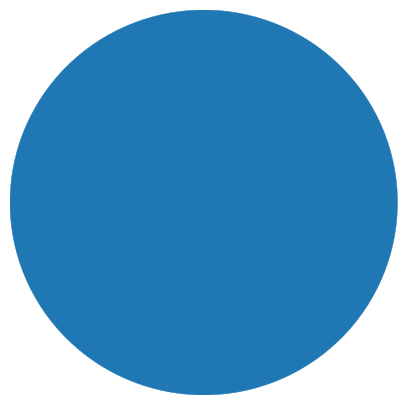

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

unit_circle = Circle((0, 0), 1, edgecolor='tab:blue', facecolor='tab:blue')
ax.add_patch(unit_circle)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.patch.set_alpha(0)
fig.patch.set_alpha(0)

savefig(fig, 'unit_circle_pdf.png')

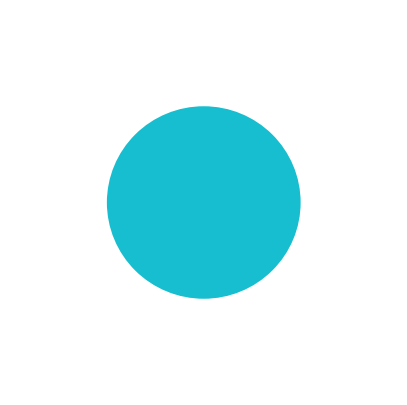

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

half_circle = Circle((0, 0), 0.5, facecolor='tab:cyan')
ax.add_patch(half_circle)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.patch.set_alpha(0)
fig.patch.set_alpha(0)

savefig(fig, 'half_circle_pdf.png')

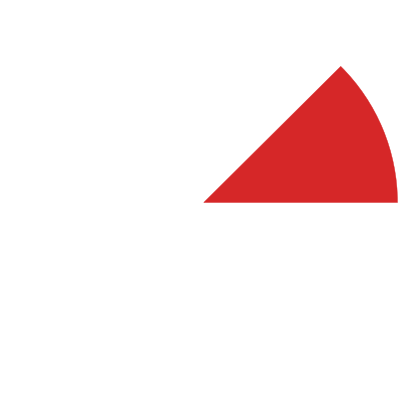

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

unit_wedge = Wedge(0, 1, 0, 45, edgecolor='tab:red', facecolor='tab:red')
ax.add_patch(unit_wedge)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.patch.set_alpha(0)
fig.patch.set_alpha(0)

savefig(fig, 'phi_circle.png')

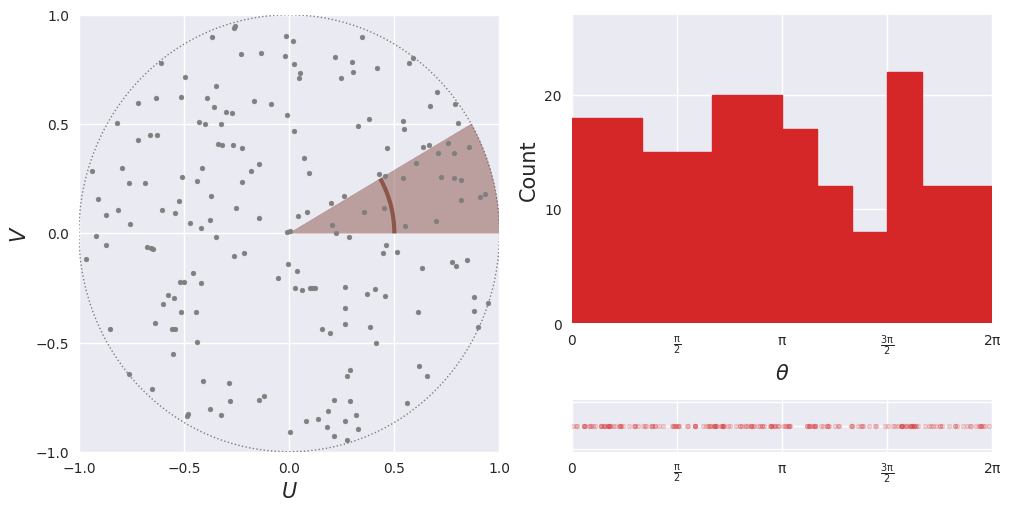

In [ ]:
fig = plt.figure(figsize=(10, 5), constrained_layout=True)
grid = plt.GridSpec(4, 8, figure=fig)

ax_uv = fig.add_subplot(grid[:4, :4])
unit_circle = Circle((0, 0), 1, edgecolor='tab:gray', facecolor='none', linestyle='dotted', linewidth=1)
wedge = Wedge(0, 1, 0, 30, edgecolor='tab:brown', facecolor='tab:brown', alpha=0.5)
arc = Arc((0, 0), 1, 1, theta1=0, theta2=30, edgecolor='tab:brown', facecolor='tab:brown', lw=3)
triangle = Polygon([(0, 0), (1, 0), (1, 1/sqrt(3))], edgecolor='tab:brown', facecolor='tab:brown', alpha=0.5)

ax_uv.add_patch(unit_circle)
ax_uv.add_artist(arc)
ax_uv.add_patch(wedge)
# ax_uv.add_patch(triangle)

ax_uv.set_xlim(-1, 1)
ax_uv.set_ylim(-1, 1)
ax_uv.set_xticks(np.linspace(-1, 1, 5))
ax_uv.set_yticks(np.linspace(-1, 1, 5))
ax_uv.set_xlabel(r'$U$')
ax_uv.set_ylabel(r'$V$')

ax_hist = fig.add_subplot(grid[:3, 4:])
ax_hist.set_xlim(0, 2*pi)
ax_hist.set_ylim(0, max_count)
ax_hist.set_xticks(np.linspace(0, 2*pi, 5))
ax_hist.set_xticklabels([r'$\mathrm{0}$', r'$\mathrm{\frac{\pi}{2}}$', r'$\mathrm{\pi}$', r'$\mathrm{\frac{3\pi}{2}}$', r'$\mathrm{2\pi}$'])
ax_hist.set_yticks(range(0, max_count, 10))
ax_hist.set_xlabel(r'$\theta$')
ax_hist.set_ylabel('Count')

ax_theta = fig.add_subplot(grid[3, 4:])
ax_theta.set_xlim(0, 2*pi)
ax_theta.set_xticks(np.linspace(0, 2*pi, 5))
ax_theta.set_xticklabels([r'$\mathrm{0}$', r'$\mathrm{\frac{\pi}{2}}$', r'$\mathrm{\pi}$', r'$\mathrm{\frac{3\pi}{2}}$', r'$\mathrm{2\pi}$'])
ax_theta.set_yticklabels([])

ax_uv.scatter(us, vs, color='tab:gray', marker='.')
ax_hist.hist(thetas, bins=np.arange(0, 2*pi+0.01, rounded_unit), color='tab:red', edgecolor='tab:red', linewidth=1)
ax_theta.scatter(thetas, np.zeros(len(thetas)), color='tab:red', marker='.', alpha=0.2)

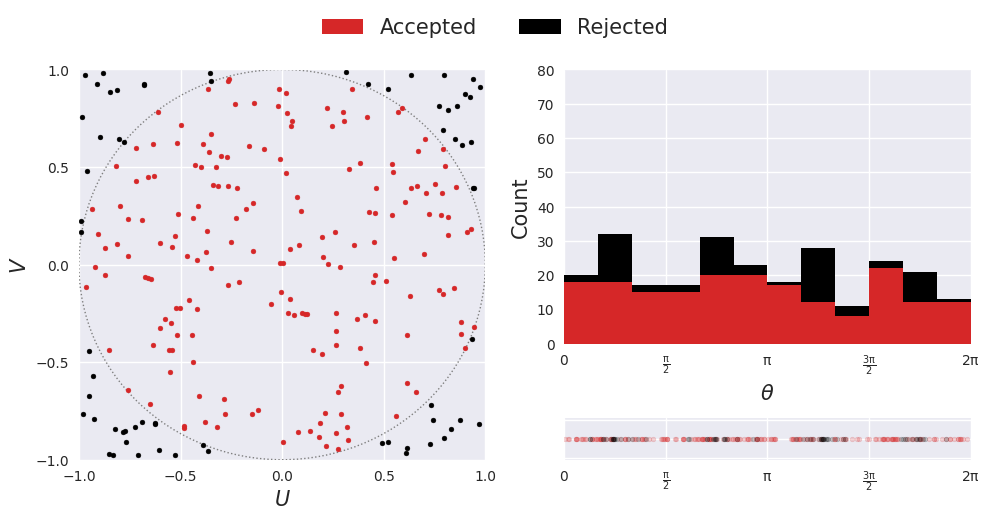

In [ ]:
fig = plt.figure(figsize=(10, 5), constrained_layout=True)
grid = plt.GridSpec(4, 8, figure=fig)

ax_uv = fig.add_subplot(grid[:4, :4])
unit_circle = Circle((0, 0), 1, edgecolor='tab:gray', facecolor='none', linestyle='dotted', linewidth=1)

ax_uv.add_patch(unit_circle)

ax_uv.set_xlim(-1, 1)
ax_uv.set_ylim(-1, 1)
ax_uv.set_xticks(np.linspace(-1, 1, 5))
ax_uv.set_yticks(np.linspace(-1, 1, 5))
ax_uv.set_xlabel(r'$U$')
ax_uv.set_ylabel(r'$V$')

ax_hist = fig.add_subplot(grid[:3, 4:])
ax_hist.set_xlim(0, 2*pi)
ax_hist.set_ylim(0, max_count)
ax_hist.set_xticks(np.linspace(0, 2*pi, 5))
ax_hist.set_xticklabels([r'$\mathrm{0}$', r'$\mathrm{\frac{\pi}{2}}$', r'$\mathrm{\pi}$', r'$\mathrm{\frac{3\pi}{2}}$', r'$\mathrm{2\pi}$'])
ax_hist.set_yticks(range(0, 81, 10))
ax_hist.set_xlabel(r'$\theta$')
ax_hist.set_ylabel('Count')

ax_theta = fig.add_subplot(grid[3, 4:])
ax_theta.set_xlim(0, 2*pi)
ax_theta.set_xticks(np.linspace(0, 2*pi, 5))
ax_theta.set_xticklabels([r'$\mathrm{0}$', r'$\mathrm{\frac{\pi}{2}}$', r'$\mathrm{\pi}$', r'$\mathrm{\frac{3\pi}{2}}$', r'$\mathrm{2\pi}$'])
ax_theta.set_yticklabels([])

ax_hist.hist([thetas, thetasr], bins=np.arange(0, 2*pi+0.01, rounded_unit), color=['tab:red', 'black'], label=['Accepted', 'Rejected'], stacked=True)
ax_uv.scatter(us, vs, color='tab:red', marker='.')
ax_uv.scatter(usr, vsr, color='black', marker='.')
ax_theta.scatter(thetas, np.zeros(len(thetas)), color='tab:red', marker='.', alpha=0.2)
ax_theta.scatter(thetasr, np.zeros(len(thetasr)), color='black', marker='.', alpha=0.2)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
savefig(fig, 'rejection_demo.png')

0
0
50
100
150
0


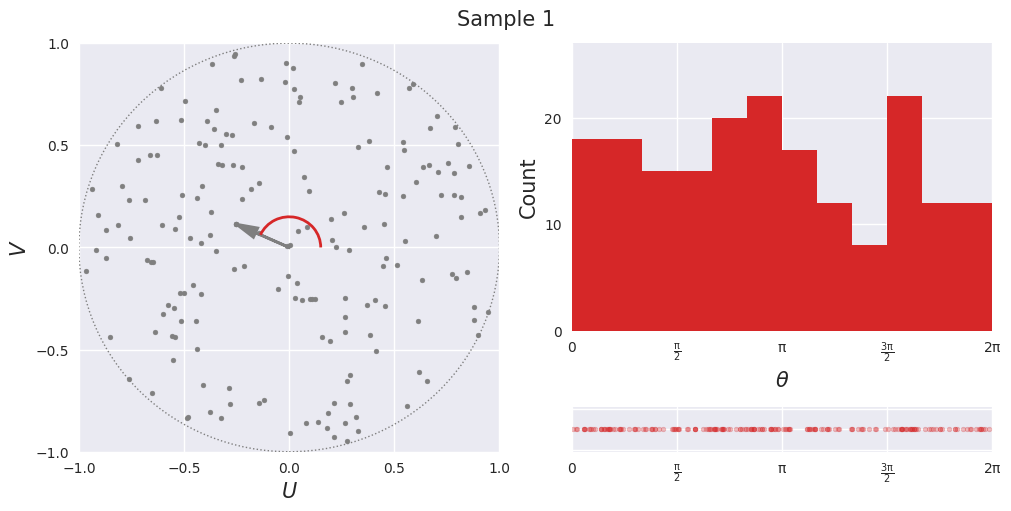

In [ ]:
def update_uv_theta(i, fig, ax_uv, ax_hist, ax_theta, verbose=False):
    if verbose and i%50==0:
        print(i)
    fig.suptitle(f'Sample {i+1}', fontsize=15)
    
    # Plot each UV sample in 2D plane, along with its corresponding theta
    u, v, theta = us[i], vs[i], thetas[i]
    ax_uv.scatter(u, v, color='tab:gray', marker='.')

    for patch in ax_uv.patches:
        if not isinstance(patch, Circle):
            patch.remove()
    ax_uv.add_patch(FancyArrow(0, 0, u, v, head_width=0.05, head_length=0.1, length_includes_head=True, color='tab:gray', lw=2))
    ax_uv.add_patch(Arc((0, 0), 0.3, 0.3, theta1=0, theta2=theta*180/pi, edgecolor='tab:red', lw=2))

    # Update histogram of thetas when each sample is generated
    rounded_theta = rounded_thetas[i]

    theta_counts.setdefault(rounded_theta, 0)
    ax_hist.add_artist(Rectangle((rounded_theta, theta_counts[rounded_theta]), rounded_unit, 1, facecolor='tab:red'))
    theta_counts[rounded_theta] += 1

    # Plot sampled theta to number line
    ax_theta.scatter(theta, 0, color='tab:red', marker='.', alpha=0.3)

fig = plt.figure(figsize=(10, 5), constrained_layout=True)
grid = plt.GridSpec(4, 8, figure=fig)

ax_uv = fig.add_subplot(grid[:4, :4])
unit_circle = Circle((0, 0), 1, edgecolor='tab:gray', facecolor='none', linestyle='dotted', linewidth=1)
ax_uv.add_patch(unit_circle)
ax_uv.set_xlim(-1, 1)
ax_uv.set_ylim(-1, 1)
ax_uv.set_xticks(np.linspace(-1, 1, 5))
ax_uv.set_yticks(np.linspace(-1, 1, 5))
ax_uv.set_xlabel(r'$U$')
ax_uv.set_ylabel(r'$V$')

ax_hist = fig.add_subplot(grid[:3, 4:])
ax_hist.set_xlim(0, 2*pi)
ax_hist.set_ylim(0, max_count)
ax_hist.set_xticks(np.linspace(0, 2*pi, 5))
ax_hist.set_xticklabels([r'$\mathrm{0}$', r'$\mathrm{\frac{\pi}{2}}$', r'$\mathrm{\pi}$', r'$\mathrm{\frac{3\pi}{2}}$', r'$\mathrm{2\pi}$'])
ax_hist.set_yticks(range(0, max_count, 10))
ax_hist.set_xlabel(r'$\theta$')
ax_hist.set_ylabel('Count')

ax_theta = fig.add_subplot(grid[3, 4:])
ax_theta.set_xlim(0, 2*pi)
ax_theta.set_xticks(np.linspace(0, 2*pi, 5))
ax_theta.set_xticklabels([r'$\mathrm{0}$', r'$\mathrm{\frac{\pi}{2}}$', r'$\mathrm{\pi}$', r'$\mathrm{\frac{3\pi}{2}}$', r'$\mathrm{2\pi}$'])
ax_theta.set_yticklabels([])

# Dict to track how many samples are in each bin of histogram
theta_counts = {}
anim = FuncAnimation(fig, lambda i: update_uv_theta(i, fig, ax_uv, ax_hist, ax_theta, verbose=True), frames=len(thetas))
anim.save('../viz/uv_theta.gif', writer=PillowWriter(fps=10))

0
0
50
100
150
0


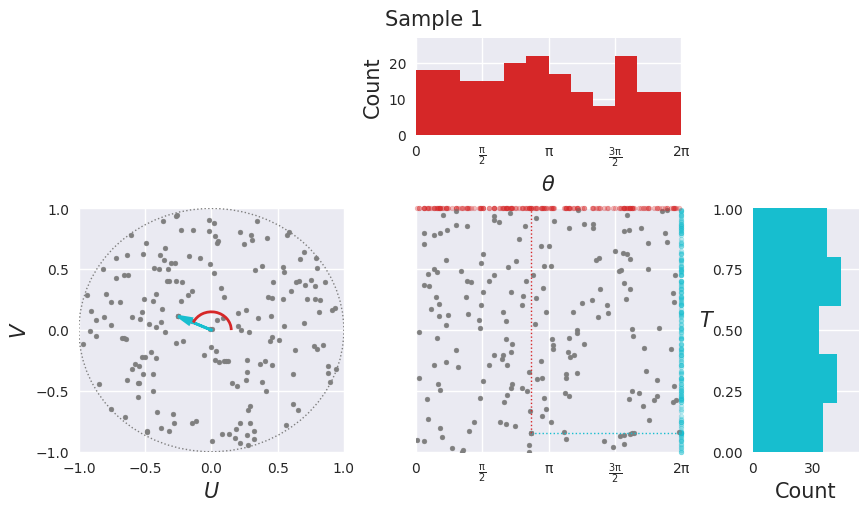

In [ ]:
fig = plt.figure(figsize=(5*12/7, 5), constrained_layout=True)
grid = plt.GridSpec(7, 12, figure=fig)

ax_uv = fig.add_subplot(grid[2:, :5])
unit_circle = Circle((0, 0), 1, edgecolor='tab:gray', facecolor='none', linestyle='dotted', linewidth=1)
ax_uv.add_patch(unit_circle)
ax_uv.set_xlim(-1, 1)
ax_uv.set_ylim(-1, 1)
ax_uv.set_xticks(np.linspace(-1, 1, 5))
ax_uv.set_yticks(np.linspace(-1, 1, 5))
ax_uv.set_xlabel(r'$U$')
ax_uv.set_ylabel(r'$V$')

ax_tt = fig.add_subplot(grid[2:, 5:10])
ax_tt.set_xlim(0, 2*pi)
ax_tt.set_ylim(0, 1)
ax_tt.set_xticks(np.linspace(0, 2*pi, 5))
ax_tt.set_xticklabels([r'$\mathrm{0}$', r'$\mathrm{\frac{\pi}{2}}$', r'$\mathrm{\pi}$', r'$\mathrm{\frac{3\pi}{2}}$', r'$\mathrm{2\pi}$'])
ax_tt.set_yticks(np.linspace(0, 1, 5))
ax_tt.set_yticklabels([])

ax_hist_theta = fig.add_subplot(grid[:2, 5:10])
ax_hist_theta.set_xlim(0, 2*pi)
ax_hist_theta.set_ylim(0, max_count)
ax_hist_theta.set_xticks(np.linspace(0, 2*pi, 5))
ax_hist_theta.set_xticklabels([r'$\mathrm{0}$', r'$\mathrm{\frac{\pi}{2}}$', r'$\mathrm{\pi}$', r'$\mathrm{\frac{3\pi}{2}}$', r'$\mathrm{2\pi}$'])
ax_hist_theta.set_yticks(range(0, max_count, 10))
ax_hist_theta.set_xlabel(r'$\theta$')
ax_hist_theta.set_ylabel('Count')

ax_hist_t = fig.add_subplot(grid[2:, 10:])
ax_hist_t.set_xlim(0, max_t_count)
ax_hist_t.set_ylim(0, 1)
ax_hist_t.set_yticks(np.linspace(0, 1, 5))
ax_hist_t.set_xticks(range(0, max_t_count, 30))
ax_hist_t.set_ylabel(r'$T$', rotation=0)
ax_hist_t.set_xlabel('Count')

def update_uv_theta(i, fig, ax_uv, ax_tt, ax_hist_theta, ax_hist_t, verbose=False):
    if verbose and i%50==0:
        print(i)
    fig.suptitle(f'Sample {i+1}', fontsize=15)
    
    # Plot each UV sample in 2D plane, along with its corresponding theta
    u, v, t, theta = us[i], vs[i], ts[i], thetas[i]
    ax_uv.scatter(u, v, color='tab:gray', marker='.')

    for patch in ax_uv.patches:
        if not isinstance(patch, Circle):
            patch.remove()
    ax_uv.add_patch(FancyArrow(0, 0, u, v, head_width=0.05, head_length=0.1, length_includes_head=True, color='tab:cyan', lw=2))
    ax_uv.add_patch(Arc((0, 0), 0.3, 0.3, theta1=0, theta2=theta*180/pi, edgecolor='tab:red', lw=2))

    # Update histogram of thetas when each sample is generated
    rounded_theta = rounded_thetas[i]
    theta_counts.setdefault(rounded_theta, 0)
    ax_hist_theta.add_artist(Rectangle((rounded_theta, theta_counts[rounded_theta]), rounded_unit, 1, facecolor='tab:red'))
    theta_counts[rounded_theta] += 1

    # Update histogram of t when each sample is generated
    rounded_t = rounded_ts[i]
    t_counts.setdefault(rounded_t, 0)
    ax_hist_t.add_artist(Rectangle((t_counts[rounded_t], rounded_t), 1, rounded_t_unit, facecolor='tab:cyan'))
    t_counts[rounded_t] += 1

    # Plot sampled theta & T
    ax_tt.scatter(theta, t, color='tab:gray', marker='.')
    ax_tt.scatter(theta, 1, color='tab:red', marker='.', alpha=0.3, clip_on=False)
    ax_tt.scatter(2*pi, t, color='tab:cyan', marker='.', alpha=0.3, clip_on=False)
    for line in ax_tt.lines:
        line.remove()
    ax_tt.add_line(Line2D([theta, 2*pi], [t, t], color='tab:cyan', linewidth=1, linestyle=':'))
    ax_tt.add_line(Line2D([theta, theta], [t, 1], color='tab:red', linewidth=1, linestyle=':'))

# Dict to track how many samples are in each bin of histogram
theta_counts = {}
t_counts = {}
anim = FuncAnimation(fig, lambda i: update_uv_theta(i, fig, ax_uv, ax_tt, ax_hist_theta, ax_hist_t, verbose=True), frames=len(thetas))
anim.save('../viz/uv_tt.gif', writer=PillowWriter(fps=10))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4e503c8f-0965-423a-a3ea-3c5fc4b3d7b6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>